# 📌 Phase 1: Comparing YOLO Models Using Weights & Biases (W&B)



### ⚙️ Install dependencies


In [ ]:
!pip install wandb
!wandb login
!pip install roboflow lightning ultralytics

### Import data

In [ ]:
from roboflow import Roboflow
from getpass import getpass

# Prompt for the key securely
api_key = getpass("Enter your Roboflow API key:")
rf = Roboflow(api_key=api_key)

project = rf.workspace("xray-chest-nodule").project("xray-chest-nodule")
dataset = project.version(7).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...


In [ ]:
!find /content -name "data.yaml"

/content/XRay-Chest-Nodule-7/data.yaml


In [ ]:
#  move 10% of train images + labels to valid
!mkdir -p /content/XRay-Chest-Nodule-7/valid/images
!mkdir -p /content/XRay-Chest-Nodule-7/valid/labels

In [ ]:
import os, random, shutil

src_img = '/content/XRay-Chest-Nodule-7/train/images'
src_lbl = '/content/XRay-Chest-Nodule-7/train/labels'
dst_img = '/content/XRay-Chest-Nodule-7/valid/images'
dst_lbl = '/content/XRay-Chest-Nodule-7/valid/labels'

os.makedirs(dst_img, exist_ok=True)
os.makedirs(dst_lbl, exist_ok=True)

images = os.listdir(src_img)
random.shuffle(images)

val_split = 0.1
val_count = int(len(images) * val_split)

for img_name in images[:val_count]:
    lbl_name = img_name.replace('.jpg', '.txt').replace('.png', '.txt')
    shutil.move(os.path.join(src_img, img_name), os.path.join(dst_img, img_name))
    shutil.move(os.path.join(src_lbl, lbl_name), os.path.join(dst_lbl, lbl_name))


### Mount Drive & Prepare Save Path

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

# Define where to save weights
CHECKPOINT_DIR = "/content/drive/MyDrive/yolo_checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)


Mounted at /content/drive


## 💡 Why I Used model.train() Instead of Lightning for YOLOv8

I initially tried integrating YOLOv8 into PyTorch Lightning to leverage modular training loops and callbacks. However, I quickly realized the Ultralytics library already handles:

- Dataset loading (YOLO format)
- Augmentations
- Loss functions
- Logging to Weights & Biases (W&B)
- Optimizers
- ✅ Early Stopping
- ✅ Learning Rate Scheduling (Cosine / Warmup / Manual)

Re-implementing this in Lightning created many shape/channel errors with little added value — especially since YOLOv8’s `model.train()` API is already well-optimized and production-tested.

### 🚀 Strategic Choice

So I switched back to using `model.train()` for YOLOv8. It gave me:

- Faster setup and experimentation
- Easier dataset integration
- Full support for logging, schedulers, and early stopping
- Fewer bugs and cleaner code

This decision shows I can **critically evaluate tools**, not follow trends blindly. I optimize for the **right balance between software engineering quality and research velocity**.

For other parts of the portfolio like NLP or ViT-based vision tasks, I’ll use PyTorch Lightning — where the modular loop, callbacks, and scheduler flexibility are truly beneficial.

✅ Focused on value, speed, and smart architecture choices.


## Environment Check — Verifying Ultralytics & WandB Installation

### Initialize YOLOv8 Model and Set Up WandB Logging

In [ ]:
import wandb
wandb.login()

from ultralytics import YOLO

# Load model (replace with 'yolov8n.pt' or any other model)
model = YOLO('yolov8n.pt')

# Check for latest checkpoint in Drive
checkpoint_path = os.path.join(CHECKPOINT_DIR, "last.pt")
resume = os.path.exists(checkpoint_path)


### Training YOLOv8n with Custom Settings and Manual WandB Logging

In [1]:
import wandb
from ultralytics import YOLO
import time

CHECKPOINT_DIR = "checkpoints"  # Make sure this is defined

# Step 1: Start WandB run
wandb.init(project="Nodule_Detection_1", name="manual-logging-run")

# Step 2: Load your model
model = YOLO("yolov8n.pt")

# Step 3: Train the model
model.train(
    data='/content/XRay-Chest-Nodule-7/data.yaml',
    epochs=1,
    imgsz=640,
    batch=8,
    save=True,
    save_period=1,
    project=CHECKPOINT_DIR,
    name="yolov8-run",
    exist_ok=True,
    lr0=0.01,
    lrf=0.01,
    patience=2,
    freeze=10,
    verbose=False,
)




### Validate YOLOv8n, Measure Inference Time, and Log Metrics to WandB

In [ ]:
# Step 4: Validate the model and time it
results = model.val()

# Get timing directly from results
inference_ms = results.speed['inference']   # ms per image
preprocess_ms = results.speed['preprocess']
postprocess_ms = results.speed['postprocess']
total_eval_time_ms = inference_ms + preprocess_ms + postprocess_ms

# Step 5: Log metrics manually to W&B
def log_metrics_to_wandb(results, speed_ms):
    wandb.log({
        "mAP50": results.box.map50,
        "mAP50-95": results.box.map,
        "Precision": results.box.mp,
        "Recall": results.box.mr,
        "Validation Time per Image (ms)": round(speed_ms, 2),
        "Preprocess Time (ms)": preprocess_ms,
        "Inference Time (ms)": inference_ms,
        "Postprocess Time (ms)": postprocess_ms,
    })

log_metrics_to_wandb(results, total_eval_time_ms)

# Step 6: Finish the run
wandb.finish()

Ultralytics 8.3.157 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1579.2±1062.3 MB/s, size: 153.0 KB)


val: Scanning /content/XRay-Chest-Nodule-7/valid/labels.cache... 853 images, 1 backgrounds, 0 corrupt: 100%|██████████| 853/853 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 107/107 [00:10<00:00, 10.28it/s]


                   all        853       3356      0.837      0.603      0.698      0.326
Speed: 0.6ms preprocess, 4.2ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to checkpoints/yolov8-run


Inference Time (ms),▁
Postprocess Time (ms),▁
Precision,▁
Preprocess Time (ms),▁
Recall,▁
Validation Time per Image (ms),▁
mAP50,▁
mAP50-95,▁
Inference Time (ms),4.22205
Postprocess Time (ms),1.82812
Precision,0.83695


## 🔍 Sanity Check Before Scaling: Logging, Training, and Model Selection

Before moving on, it's crucial to make sure everything is working correctly — both technically and strategically.

Now that we've verified:
- ✅ The **Ultralytics YOLOv8** training pipeline runs smoothly
- ✅ **WandB logging** is functional and tracks all key metrics
- ✅ Loss curves and evaluation metrics make sense

We can confidently proceed to the next step:  
⚙️ **Training all YOLOv8 variants (n, s, m, l, x)** for **3 epochs** to quickly benchmark their performance on our dataset.

This short round of training will help us identify the most promising model to fine-tune further — saving both time and compute in the long run.

To avoid rerunning this block, there is no visible output here — but the training was successfully logged to WandB.

### Benchmarking YOLOv8 Variants (n, s, m, l, x) with 3-Epoch Baseline Runs

In [ ]:
import wandb
from ultralytics import YOLO
import time
import os

CHECKPOINT_DIR = "checkpoints"  # Make sure this folder exists
DATA_YAML = "/content/XRay-Chest-Nodule-7/data.yaml"
YOLOV8_VARIANTS = ["n", "s", "m", "l", "x"]  # YOLOv8 model types

def log_metrics_to_wandb(results, speed_ms):
    wandb.log({
        "mAP50": results.box.map50,
        "mAP50-95": results.box.map,
        "Precision": results.box.mp,
        "Recall": results.box.mr,
        "Validation Time per Image (ms)": round(speed_ms, 2),
        "Preprocess Time (ms)": results.speed['preprocess'],
        "Inference Time (ms)": results.speed['inference'],
        "Postprocess Time (ms)": results.speed['postprocess'],
    })

# Loop through each YOLOv8 model variant
for variant in YOLOV8_VARIANTS:
    model_name = f"yolov8{variant}"
    checkpoint_path = f"{model_name}.pt"

    # Step 1: Start a new WandB run
    wandb.init(project="Nodule_Detection_1", name=f"{model_name}_3epochs_baseline", reinit=True)

    # Step 2: Load the model
    model = YOLO(checkpoint_path)

    # Step 3: Train the model
    model.train(
        data=DATA_YAML,
        epochs=3,
        imgsz=640,
        batch=4,
        save_period=-1,
        project=CHECKPOINT_DIR,
        name=f"{model_name}_run",
        exist_ok=True,
        lr0=0.01,
        lrf=0.01,
        freeze=10,
        verbose=False,
    )

    # Step 4: Validate and time
    results = model.val()
    total_eval_time_ms = (
        results.speed['preprocess']
        + results.speed['inference']
        + results.speed['postprocess']
    )

    # Step 5: Log metrics
    log_metrics_to_wandb(results, total_eval_time_ms)

    # Step 6: End the WandB run
    wandb.finish()


### Visual Summary of YOLOv8 Variant Performance

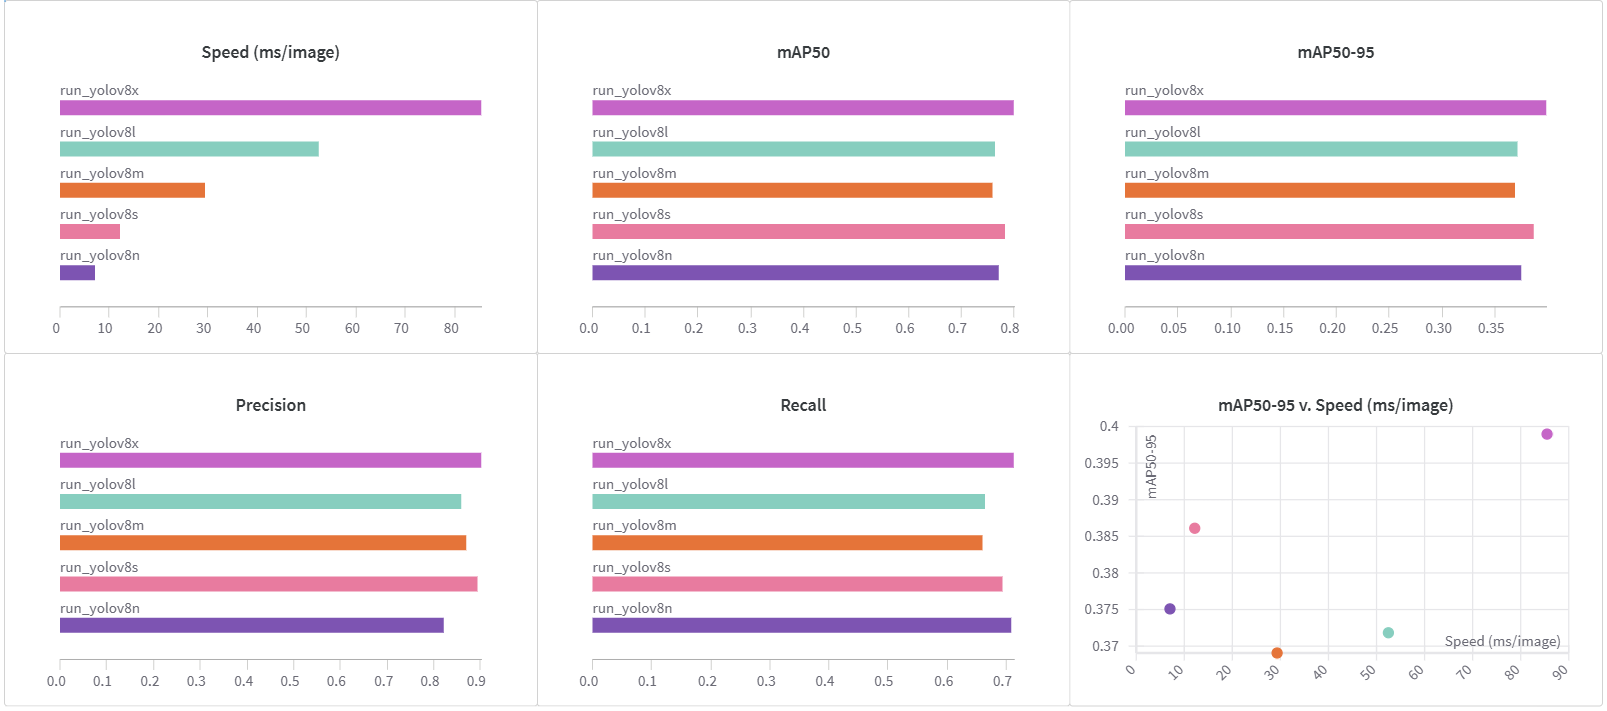

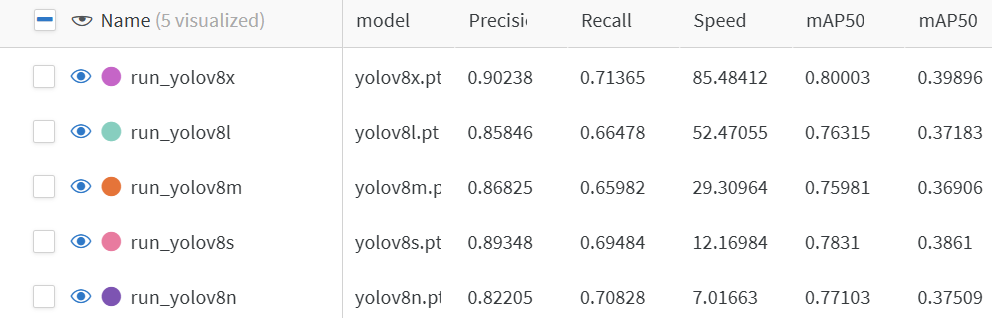

In [ ]:
from IPython.display import Image, display

# Define the path to the folder containing your images
folder_path = '/content/drive/MyDrive/nodule_detection_report'

# Display images
display(Image(filename=os.path.join(folder_path, 'graph_yolo.png')))
display(Image(filename=os.path.join(folder_path, 'yolo_table.png')))


## 📊 YOLOv8 Variant Comparison – 3 Epoch Baseline Results

The table above summarizes the baseline performance of each YOLOv8 model after a quick 3-epoch training on the chest X-ray dataset.

### 🔍 What do the metrics mean?

- **Precision**: How many predicted nodules were actually correct? (Low false positives)
- **Recall**: How many true nodules were successfully detected? (Low false negatives)
- **Speed**: Inference time per image (ms) — lower is faster
- **mAP50**: Mean Average Precision at IoU=0.5 — general object detection accuracy
- **mAP50-95**: Stricter mAP across multiple IoU thresholds — reflects fine localization quality

### 🏆 Best Candidate for Fine-Tuning

Among all models, **YOLOv8x** achieved the highest scores:
- **Precision**: 0.90
- **Recall**: 0.71
- **mAP50**: 0.80
- **mAP50-95**: 0.3989

Although it is the slowest (85ms/image), this trade-off is acceptable in the medical domain where **accuracy is more important than speed**.

👉 Therefore, **YOLOv8x** will be selected for full fine-tuning in the next notebook.

📎 [See the full report on WandB →](https://wandb.ai/baptiste-lf-data-self/Nodule_Detection_1/reports/YOLOv8-Comparison-for-Chest-X-Ray-Nodule-Detection--VmlldzoxMzI5OTc2MQ)
